- Se pravat 2 grafovi: prviot e so blok dijagonalna matrica na sosedstvo, reprezentira familii, vtoriot e vakov LFR_benchmark graf kade site nodes koi pripagjaat vo "community" na daden node ke se smetaat za pobliski prijateli, dodeka site ostanati vrski se smetaat za podalecni prijateli
- Vo familija ke ima najgolema shansa za zarazlivost, megju bliski prijateli pomala, megju podalecni najmala
- Moze da se poigra so "siva masa" kade so mnogu mal procent lugeto se zarazuvaat od nepoznat izvor (bez kontakt so drug covek)
- Da se definira distribucija na denovi za od exposed da se premine vo infected i od infected vo recovered
- Da se definira razlika pomegju exposed i infected node pri zarazuvanje na sosednite nodes (primer exposed gi zarazuva site, no infected zarazuva samo clenovi na familija, bidejki e izoliran)
- Mozebi da se napravi SEIRS model, bidejki lice koe ja prelezalo bolesta gi ima antitelata odredeno vreme, a potoa povtorno moze da se zarazi
- Dinamicka promena na gledanje so prijateli i ostanati vrski (primer na pocetok ne se pocituvaat merki i se gledame so niv sekoj den, koga ke stigne brojot na infected nad odreden threshold se voveduvaat odredeni merki, no tie ne mozat da traat predolgo radi ekonomski pricini, pa se olabavuvaat po odreden period itn.)
***

- Currently,  there  is  no  clear  evidence  that  COVID-19  asymptomatic  persons  can  transmit  SARS-CoV-2,  but  there  is  accumulating  evidence  indicating  that  a  sub-stantial fraction of SARS-CoV-2 infected individuals are asymptomatic [10-12].
- http://med.stanford.edu/content/dam/sm/id/documents/COVID/AsymptCOVID_TransmissionShip.pdf asymp. proportion (P(E->R))
***

In [1]:
import itertools
import networkx as nx
import random as rn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from copy import deepcopy

rn.seed(42)
colors = ["#313695", "#a50026", "#fee838", "#004529"]
status = ["suspectible", "exposed", "infected", "recovered"]

%matplotlib inline

In [53]:
def derivative(y, t, N, t_se, t_ei, t_ir, t_er, t_rs, p_E_to_R):
    S, E, I, R = y

    dSdt = (R/t_rs) - (S*I/N*t_se)
    dEdt = (S*I/N*t_se) - (E/t_er)*p_E_to_R - (E/t_ei)*(1-p_E_to_R) 
    dIdt = (E/t_ei)*(1-p_E_to_R)-I/t_ir
    dRdt = I/t_ir - R/t_rs
    return dSdt, dEdt, dIdt, dRdt


def calculate_new_states(graph=None, days=1, exposed_0=5):
    # N = graph_size
    N = 1000
    y0 = N-exposed_0, exposed_0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    
    # Draw from distributions 
    t_se = 10.0
    t_ei = 7.0
    t_ir = 14.0 
    t_er = 14.0
    t_rs = 60
    p_E_to_R = 0.179
    
    ret = odeint(derivative, y0, t, args=(N, t_se, t_ei, t_ir, t_er, t_rs, p_E_to_R))
    S, E, I, R = ret.T

    return S, E, I, R


def decision(probability):
    return rn.random() < probability


def plot_seir(sus, exp, inf, rec, num_days):
    fig = plt.figure(figsize=(18,10))
    plt.plot(range(num_days), sus, c=colors[0])
    plt.plot(range(num_days), exp, c=colors[1])
    plt.plot(range(num_days), inf, c=colors[2])
    plt.plot(range(num_days), rec, c=colors[3])
    plt.legend(status)
    plt.title("SEIR graph for simulation that lasted {} days".format(num_days))
    plt.show()


def generate_graph(num_nodes, tau1=2, tau2=5, mu=0.1, max_degree=15, average_degree=5,
                   min_community=6, max_community=30):
    G = nx.LFR_benchmark_graph(num_nodes, tau1, tau2, mu, average_degree, max_degree=max_degree,
                               min_community=min_community, max_community=max_community, seed=42)
    nx.set_node_attributes(G, 0, "status")
    nx.set_node_attributes(G, -1, "asymp")
    return add_families_to_graph(G, num_nodes)


def add_families_to_graph(F, num_population):
    # Used 2019 USA demographics to get these numbers
    num_family_members = [1, 2, 3, 4, 5, 6, 7]
    probabilities = [0.2837, 0.3451, 0.1507, 0.1276, 0.0578, 0.0226, 0.0125] 
    families = rn.choices(num_family_members, probabilities, k=num_population//2)
    n, i = 0, 0
    while n < num_population:
        if n + families[i] > num_population:
            k = num_population - n
        else:
            k = families[i]
        fam = [x for x in range(n, n+k)]
        edges = itertools.combinations(fam,2)
        F.add_edges_from(edges)
        for j in range(k):
            F.nodes[n+j]['family'] = fam
        n = n+k
        i = i+1
    return F


def plot_graph(G):
    fig, ax = plt.subplots(figsize=(18,10))
    node_color = [colors[x] for x in nx.get_node_attributes(G, "status").values()]
    pos = nx.spring_layout(G)
    for i in range(len(status)):
        node_subset = [x for x, y in G.nodes(data=True) if y["status"]==i]
        nx.draw_networkx_nodes(G, pos=pos, ax=ax, nodelist=node_subset, node_size=100,
                               node_color=colors[i], label=status[i], alpha=.75)
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="#a2a2a2", alpha=.75)
    plt.legend()
    
    
def run_simulation(G, num_days, initial_exposed, plot=False, families = False):
    num_nodes = len(G.nodes)
    sus = []
    exposed = rn.sample(range(0, num_nodes-1), initial_exposed)
    for i in range(num_nodes):
        if i not in exposed:
            sus.append(i)
            G.nodes[i]["status"] = 0
            G.nodes[i]["asymp"] = -1
    infected = []
    recovered = []
    
    for i in exposed:
        G.nodes[i]["status"] = 1
        G.nodes[i]["asymp"] = -1
    
    S = [num_nodes - initial_exposed]
    E = [initial_exposed]
    I = [0]
    R = [0]
    
    # Draw from distributions 
    t_se = 10.0
    t_ei = 7.0
    t_ir = 14.0 
    t_er = 14.0
    t_rs = 60
    comm_talk_freq = 3.0
    other_talk_freq = 10.0
    p_E_to_R = 0.179
    
    status = {"sus":0, "exp":1, "inf":2, "rec":3}
    
    for i in range(num_days):
        new_exposed = []
        for j in range(num_nodes):
            # recovered to susceptible
            sus_now = False
            if G.nodes[j]["status"] == status["rec"]:
                p_r_to_s = 1/t_rs
                choice = decision(p_r_to_s)
                if choice == True:
                    G.nodes[j]["status"] = status["sus"]
                    recovered.remove(j)
                    sus.append(j)
                    rec_now = True
            # susceptible to exposed
            exp_now = False
            if G.nodes[j]["status"] == status["sus"] and not sus_now:
                neighbors = [n for n in G.neighbors(j)]
                total_neighbors = len(neighbors)
                inf_community = 0.0
                inf_other = 0.0
                for neighbor in list(neighbors):
                    if G.nodes[neighbor]["status"] == status["inf"]:
                        if families and G.nodes[neighbor]["family"] == G.nodes[j]["family"]:
                            G.nodes[j]["status"] = status["exp"]
                            sus.remove(j)
                            exposed.append(j)
                            exp_now = True
                            break
                        elif neighbor in G.nodes[j]["community"]:
                            inf_community+=1
                        else:
                            inf_other+=1
                if not exp_now:
                    p_s_to_e = (inf_community/(comm_talk_freq) + inf_other/(other_talk_freq) )* 0.8
                    choice = decision(p_s_to_e)
                    if choice == True:
                        G.nodes[j]["status"] = status["exp"]
                        sus.remove(j)
                        exposed.append(j)
                        exp_now = True
            # exposed to infected/recovered
            inf_now = False
            if G.nodes[j]["status"] == status["exp"] and not exp_now:
                if G.nodes[j]["asymp"]!=-1:
                    if G.nodes[j]["asymp"] == 1:
                        choice = decision(1/t_er)
                        if choice == True:
                            G.nodes[j]["status"] = status["rec"]
                            exposed.remove(j)
                            recovered.append(j)
                    else:
                        choice = decision(1/t_ei)
                        if choice == True:
                            G.nodes[j]["status"] = status["inf"]
                            exposed.remove(j)
                            infected.append(j)
                            inf_now = True
                else:
                    choice = decision(p_E_to_R)
                    if choice == True:
                        G.nodes[j]["asymp"] = 1
                        choice = decision(1/t_er)
                        if choice == True:
                            G.nodes[j]["status"] = status["rec"]
                            exposed.remove(j)
                            recovered.append(j)
                    else:
                        G.nodes[j]["asymp"] = 0
                        choice = decision(1/t_ei)
                        if choice == True:
                            G.nodes[j]["status"] = status["inf"]
                            exposed.remove(j)
                            infected.append(j)
                            inf_now = True
            # infected to recovered
            if G.nodes[j]["status"] == status["inf"] and not inf_now:
                p_i_to_r = 1/t_ir
                choice = decision(p_i_to_r)
                if choice == True:
                    G.nodes[j]["status"] = status["rec"]
                    infected.remove(j)
                    recovered.append(j)
        S.append(num_nodes - len(exposed) - len(infected) - len(recovered))
        E.append(len(exposed))
        I.append(len(infected))
        R.append(len(recovered))
        
    plot_seir(S, E, I, R, num_days + 1)
    if plot:
        plot_graph(G)

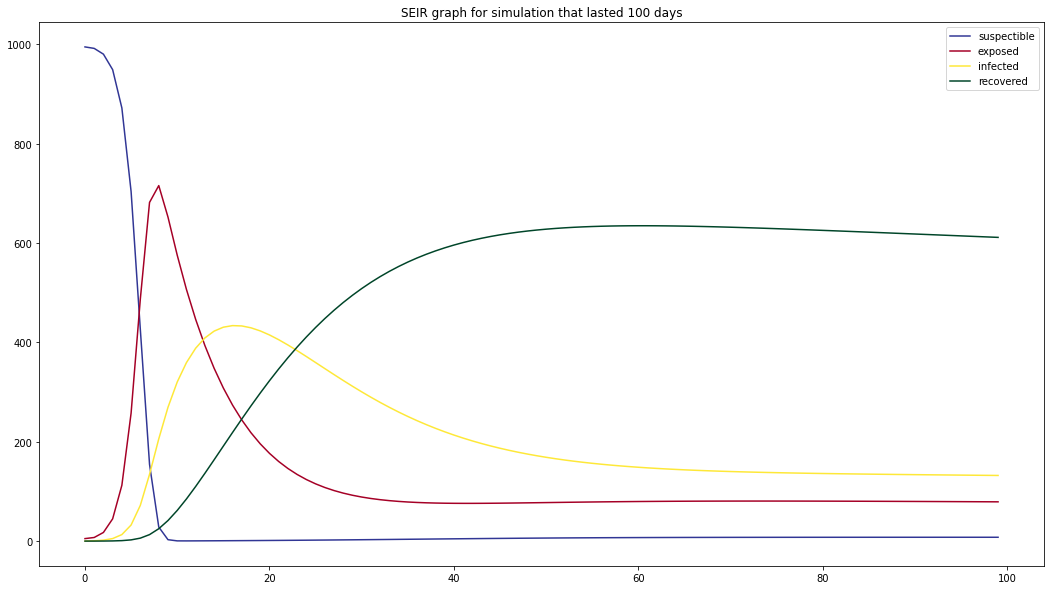

In [48]:
days = 100
res_100 = calculate_new_states(days = days)
plot_seir(res_100[0],res_100[1],res_100[2],res_100[3],days)

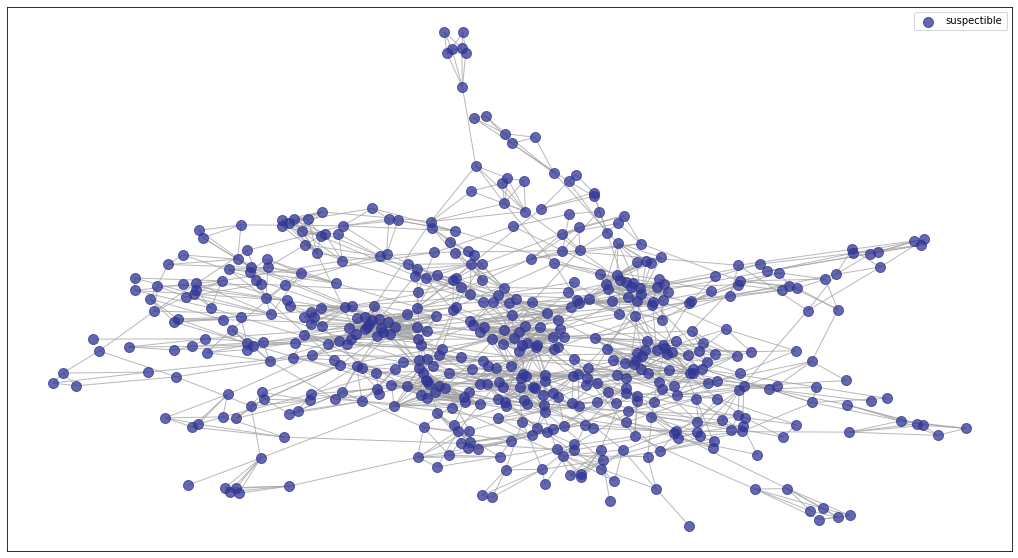

In [49]:
num_nodes = 501
G = nx.LFR_benchmark_graph(num_nodes, 2, 5, 0.1, max_degree=15, average_degree=5,
                           min_community=6, max_community=30, seed=42)
nx.set_node_attributes(G, 0, "status")
nx.set_node_attributes(G, 0, "days")
plot_graph(G)

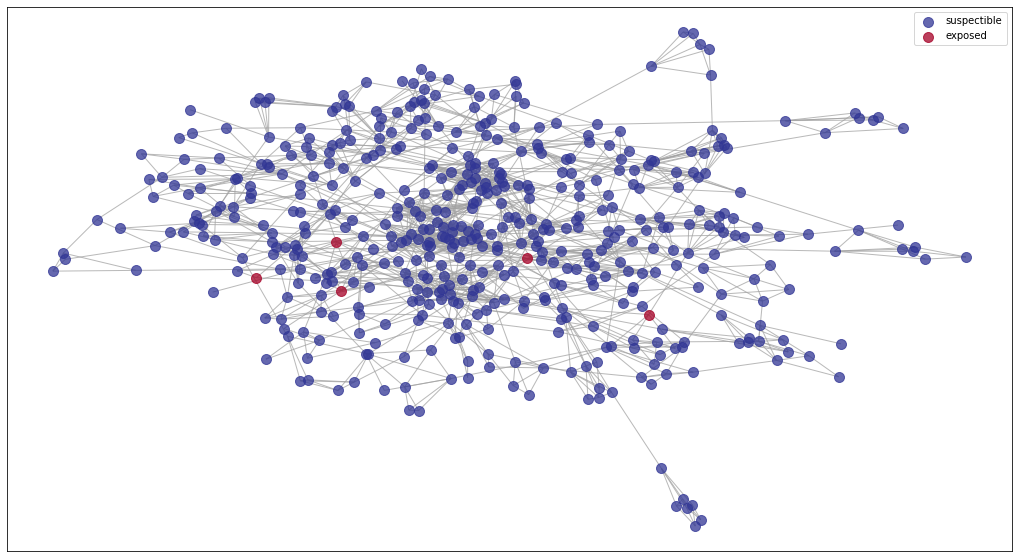

In [50]:
initial_exposed = 5
exposed = [rn.randint(0, num_nodes-1) for i in range(initial_exposed)]
infected = []
recovered = []
G_copy = deepcopy(G)
for i in exposed:
    G.nodes[i]["status"] = 1
plot_graph(G)

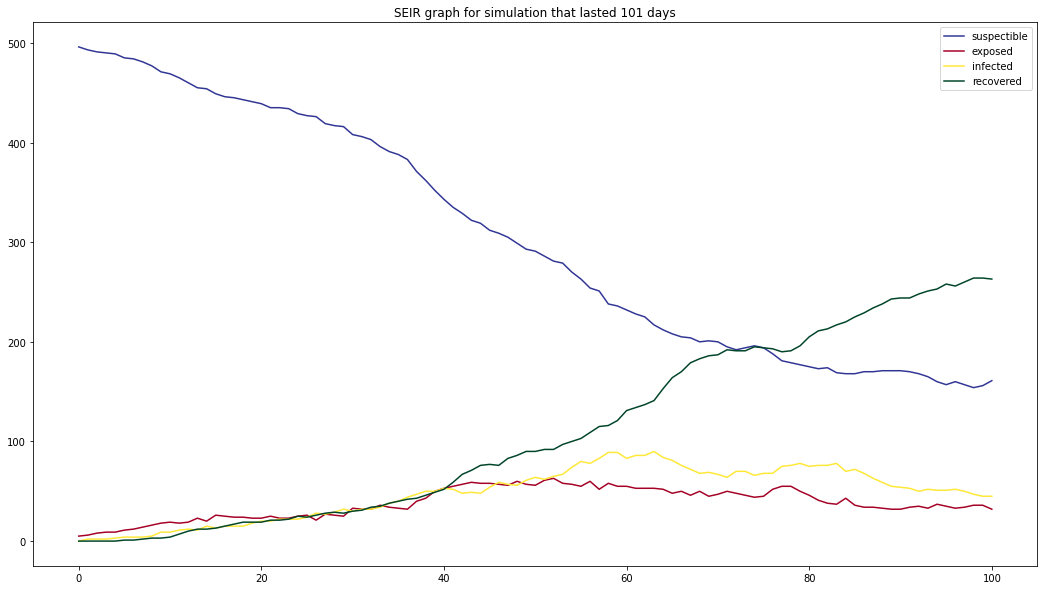

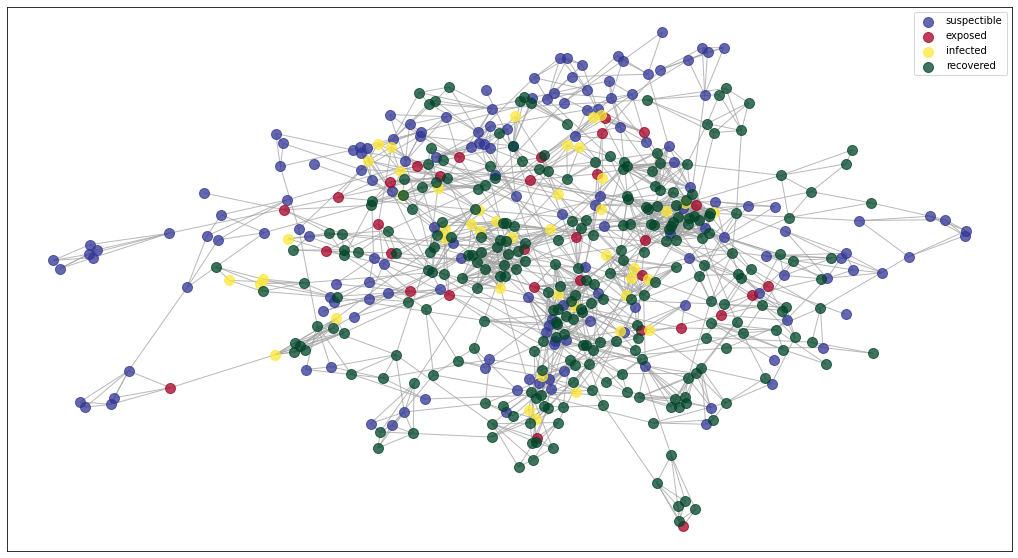

In [54]:
run_simulation(G_copy,100,initial_exposed,True)

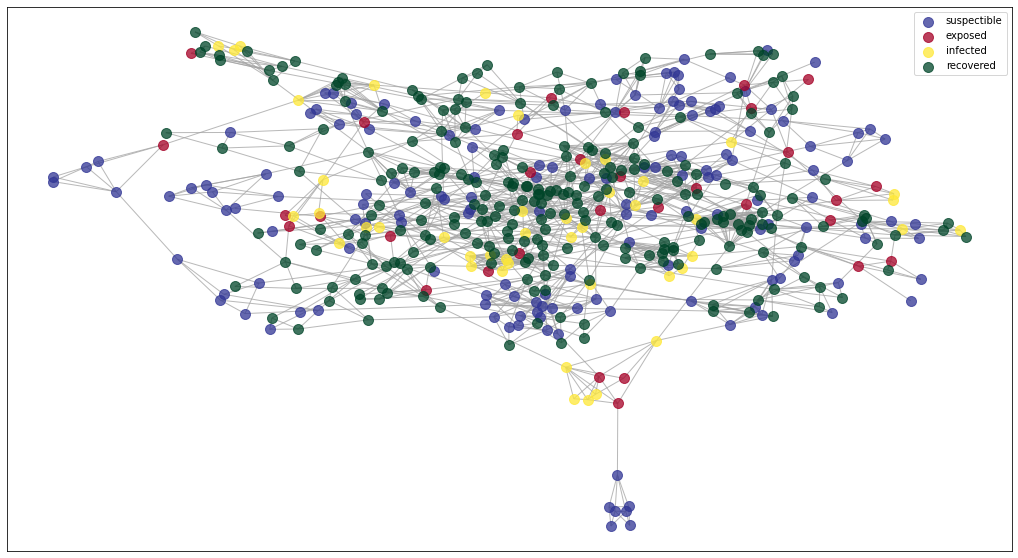

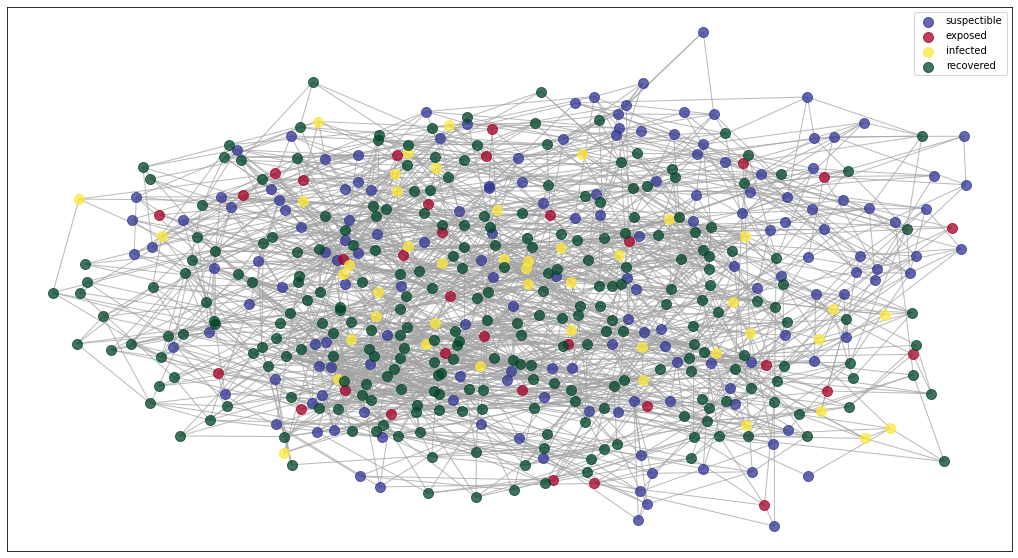

In [55]:
F = add_families_to_graph(deepcopy(G_copy), num_nodes)
plot_graph(G_copy)
plot_graph(F)

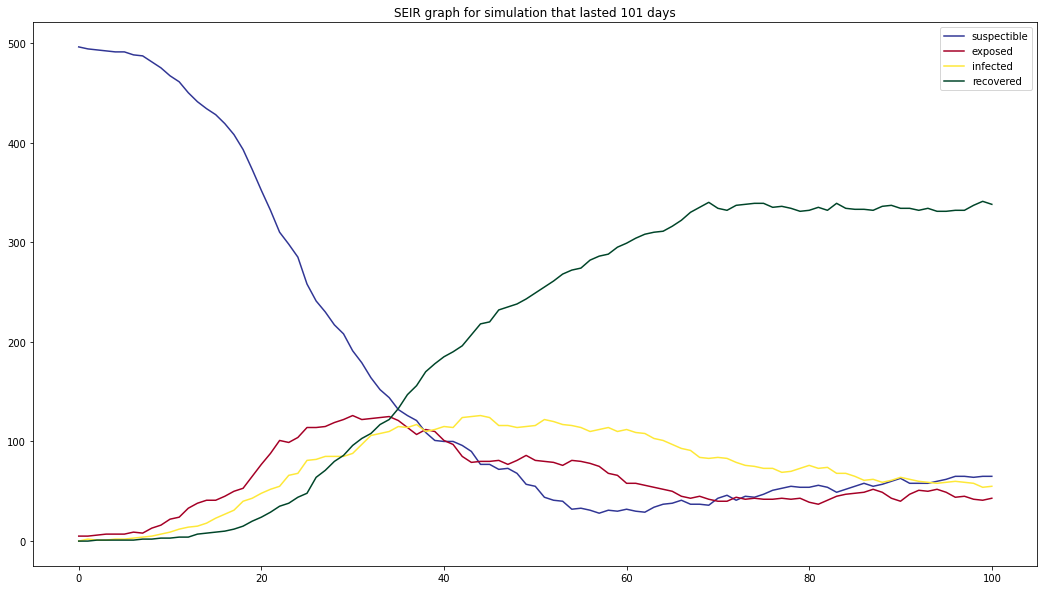

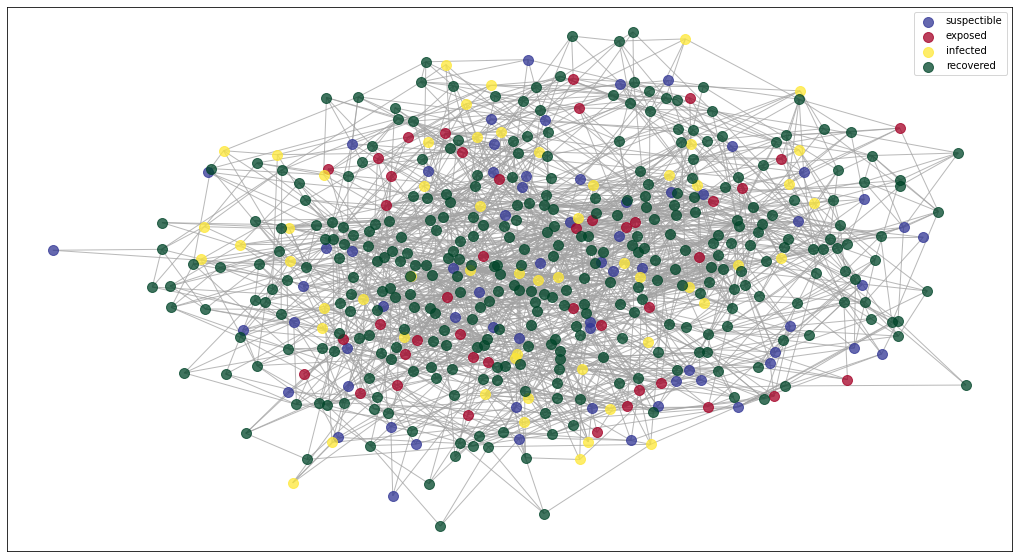

In [56]:
run_simulation(F, num_days=100, initial_exposed=5, plot=True)

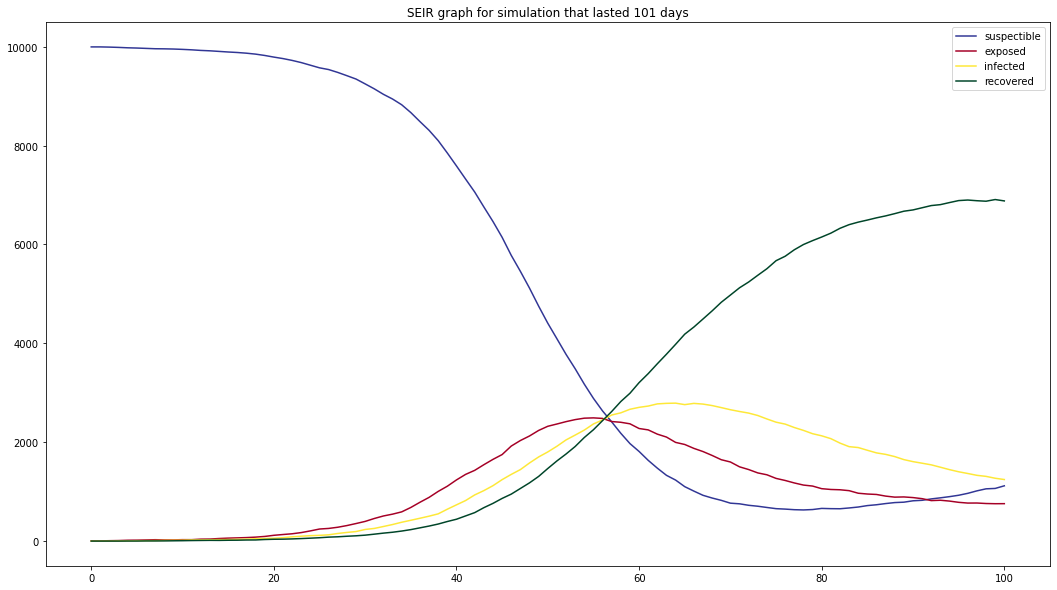

In [57]:
G = generate_graph(int(1e4))
run_simulation(deepcopy(G), num_days=100, initial_exposed=5)

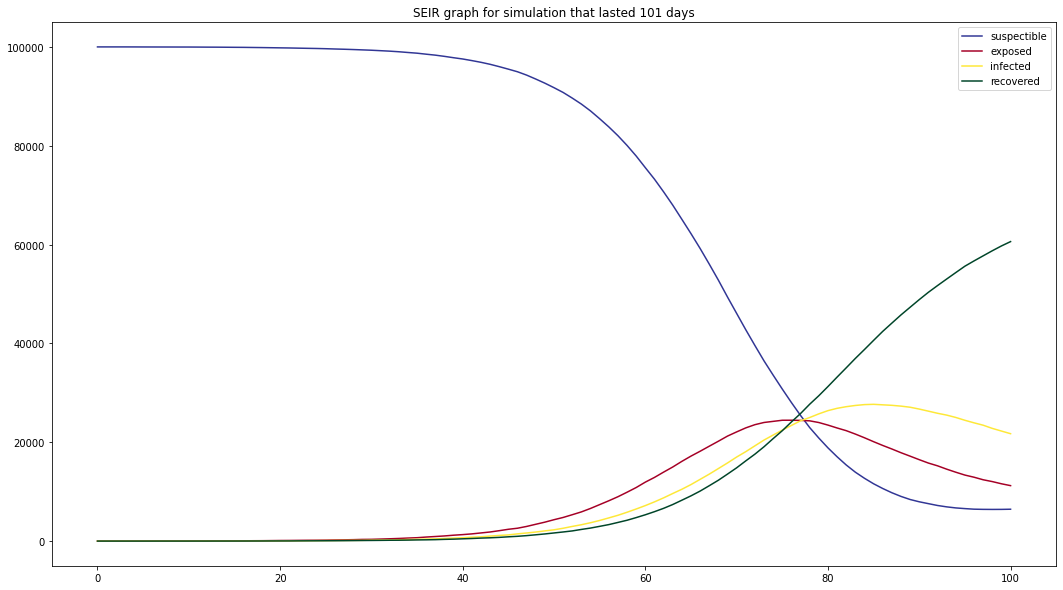

In [58]:
G = generate_graph(int(1e5))
run_simulation(deepcopy(G), num_days=100, initial_exposed=5)